<a href="https://colab.research.google.com/github/AbrahamKong/CMPE257-NLP_AlternusVera/blob/master/AlternusVera_Corpus_Style_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alternus Vera 

-----

GitHub URL: 


### Liar Liar Pants on Fire Dataset Description 
- It has 3 files test, training and valid.
- Each file has 14 columns
    
    Column 1: the ID of the statement ([ID].json).
    
    Column 2: the label.
    
    Column 3: the statement.
    
    Column 4: the subject(s).
    
    Column 5: the speaker.
    
    Column 6: the speaker's job title.
    
    Column 7: the state info.
    
    Column 8: the party affiliation.
    
    Column 9-13: the total credit history count, including the current statement.
    
    Column 14: the context (venue / location of the speech or statement).

### Process 
- Load the Data
- Distillation Process
    - Data Cleaning and Text Preprocessing
    - Visualization
- **Feature 1 :** Corpus Style 
    

### Team Contributions example:

|Features  |  Member |
|-----|-----|
| Feature name(s)                         |  Member name(s) |  
| Feature name(s)                 |  Member name(s) | 
| Feature name(s)                   |  Member name(s)  |   
| Feature name(s)                             |  Member name(s) |



#### What did I try and What worked? 

> Explain your work ...

#### What did not work?

> Explain your work ...


#### What alternatives did you try?

> Explain your work 

----

# Data Pre-process

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
file_path_data = "/content/drive/MyDrive/SJSU/CMPE 257: Machine Learning/NLP/AlternusVera/input_data"

In [3]:
your_team="Data Miners/NLP-Alternus Vera/input_data"
# file_path_data ="/content/drive/MyDrive/ML-Spring-2022/"+your_team
import os
os.chdir(file_path_data)

### Reading the Data

In [4]:
# !pip install selenium
# !pip install newspaper3k
# ! pip install beautifulsoup4
# ! pip install requests

In [5]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
# Read the test, training and valid data from files
# Header = 0 indicates that the first line of the file contains column names,
# As there is no Header, create a column names for each column in the dataset
# delimiter = \t indicates that the fields are seperated by tabs, and 


# test_filename = 'input_data/dataset/test.tsv'
# train_filename = 'input_data/dataset/train.tsv'
# valid_filename = 'input_data/dataset/valid.tsv'

test_filename = file_path_data + '/test.tsv'
train_filename = file_path_data + '/train.tsv'
valid_filename = file_path_data + '/valid.tsv'

colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']

train_news = pd.read_csv(train_filename, sep='\t', names = colnames, error_bad_lines=False)
test_news = pd.read_csv(test_filename, sep='\t', names = colnames, error_bad_lines=False)
valid_news = pd.read_csv(valid_filename, sep='\t', names = colnames, error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# Display check the dimensions and the first 2 rows of the file.

print('train dim:',train_news.shape, 'test dim:', test_news.shape)
train_news.iloc[0:2]

train dim: (10240, 14) test dim: (1267, 14)


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


## Data Cleaning and Text Preprocessing 

*Steps included in the preprocessing:*
- Remove Special Characters and Punctuations
- Lower case the news
- Tokenization
- Remove Stop Words
- Lemmatization
- Stemming 
- Spell Check 

###  Putting It All Together 

To make the code reusable, we need to create a function that can be called many times.

In [8]:
def cleaning(raw_news):
    # import nltk
    # nltk.download('punkt')
    # nltk.download('wordnet')
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [9]:
import time
# clean training and test data 
# create new column "tokenized"
t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
import nltk
nltk.download('punkt')
nltk.download('wordnet')
train_news['clean'] = train_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem train data: \n", len(train_news), "news:", (t2-t1)/60, "min")

t1 = time.time()
test_news['clean'] = test_news["headline_text"].apply(cleaning)

t2 = time.time()
print("\n\nTime to clean, tokenize and stem test data: \n", len(test_news), "news:", (t2-t1)/60, "min")

t1 = time.time()
valid_news['clean'] = valid_news["headline_text"].apply(cleaning)

t2 = time.time()
print("\n\nTime to clean, tokenize and stem valid data: \n", len(valid_news), "news:", (t2-t1)/60, "min")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.

Time to clean, tokenize and stem train data: 
 10240 news: 0.14436086813608806 min


Time to clean, tokenize and stem test data: 
 1267 news: 0.013171279430389404 min


Time to clean, tokenize and stem valid data: 
 1284 news: 0.01315381129582723 min


### [Google News corpus word2vec](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/)

### Spell Check 

-  You can download the pre-trained model [**here**](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

- Or clone it from GitHub [**GoogleNews-vectors-negative300**](https://github.com/mmihaltz/word2vec-GoogleNews-vectors)

> It’s 1.5GB! It includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset. The vector length is 300 features.

**3 million words * 300 features * 4bytes/feature = ~3.35GB**

> This file consist of the word2vec -  pre-trained Google News corpus (3 billion running words) to word vector model (3 million 300-dimension English word vectors).

> Look at the [**vocabulory list**](https://github.com/chrisjmccormick/inspect_word2vec/tree/master/vocabulary) used to train this model. Each text file contains 100,000 entries from the model. 


>  There are few things that this dataset contains and not. It has stop words like  “the”, “also”, “should” and does not have stop words like “a”, “and”, “of”. As I have removed the stop words the complexity is reduced as there is no need to check the spelling for stop words. 

> It does have numbers but in the form of entried wiht #. e.g., you won’t find “100”. But it does include entries like “###MHz_DDR2_SDRAM”. 

The model used [**WinPython-64bit-2.7.10.3**](https://winpython.github.io/) for efficient python distribution on Windows system. Helps to run the scripts in batches. 

In [10]:
# model = gensim.models.KeyedVectors.load_word2vec_format('input_data/GoogleNews-vectors-negative300.bin.gz', binary=True)
model = gensim.models.KeyedVectors.load_word2vec_format((file_path_data + '/GoogleNews-vectors-negative300.bin.gz'), binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [11]:
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [12]:
def spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)

In [13]:
print("Before: \n", train_news['clean'][0] )
t1 = time.time()
train_news['clean'] = train_news['clean'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the train data: \n", len(train_news), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",train_news['clean'][0] )
train_news.head(5)

Before: 
 say anni list polit group support third trimest abort demand

Time to spell check the train data: 
 10240 news: 5.35852872133255 min

After: 
 say anni list polit group support third trimmest abort demand


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimme...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start start natur gas took start ...
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agre john mccain vote give geo...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legis like mandat free sex ...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term


In [14]:
t1 = time.time()
test_news['clean'] = test_news['clean'].apply(spell_checker)
test_news.head(5)
t2 = time.time()
print("\nTime to spell check the test data: \n", len(test_news), "news:", (t2-t1)/60, "min")


Time to spell check the test data: 
 1267 news: 0.5342839082082113 min


In [15]:
t1 = time.time()
valid_news['clean'] = valid_news['clean'].apply(spell_checker)
valid_news.head(5)
t2 = time.time()
print("\nTime to spell check the valid data: \n", len(valid_news), "news:", (t2-t1)/60, "min")


Time to spell check the valid data: 
 1284 news: 0.5803258577982585 min


##### Saved the trained dataset into a seperate CSV file 

In [16]:
# train_news.to_csv("input_data/train_processed.csv", sep=',')
# test_news.to_csv("input_data/test_processed.csv", sep=',')
# valid_news.to_csv("input_data/valid_processed.csv", sep=',')
train_news.to_csv((file_path_data + '/train_processed.csv'), sep=',')
test_news.to_csv((file_path_data + '/test_processed.csv'), sep=',')
valid_news.to_csv((file_path_data + '/valid_processed.csv'), sep=',')

### Visualization 

#### WordCloud 

> As a tool for visualization by using the frequency of words appeared in text, we use WordCloud. Note that it can give more information and insight of texts by analyzing correlations and similarities between words rather than analyzing texts only by the frequency of words appeared; however, it can give you some general shape of what this text is about quickly and intuitively.

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

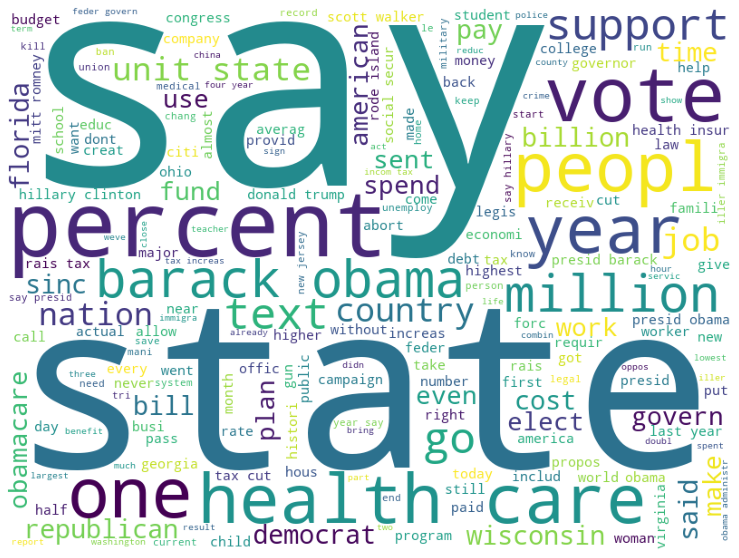

In [18]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(train_news['clean']))

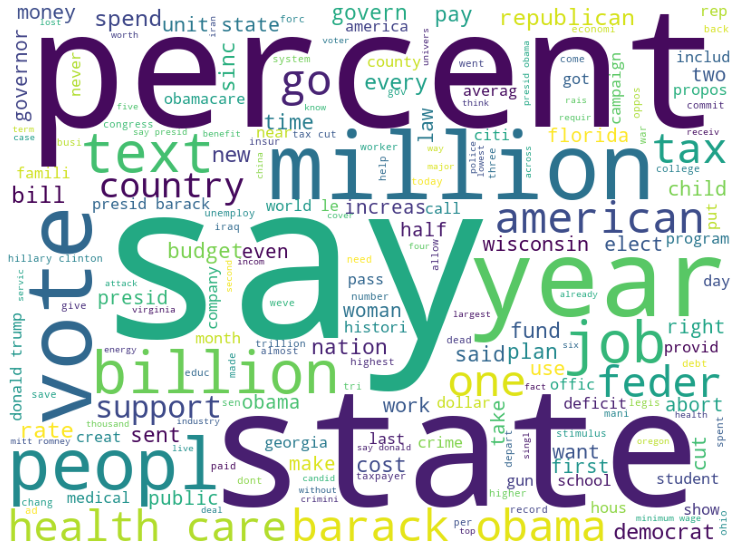

In [19]:
cloud(' '.join(test_news['clean']))

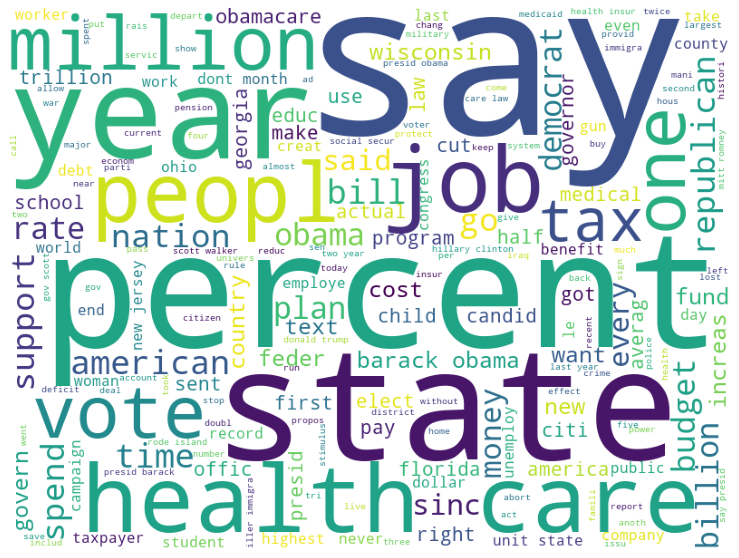

In [20]:
cloud(' '.join(valid_news['clean']))

#### Inferences from visulaization: 
- The large words are the words that are frequently appeared in the text/corpus

# Feature: Corpus Style

### Import necessary Libraries

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics

### Import Data Set

In [22]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

train_news = pd.read_csv((file_path_data + '/train.tsv'), sep='\t', names = colnames, error_bad_lines=False)
test_news = pd.read_csv((file_path_data + '/test.tsv'), sep='\t', names = colnames, error_bad_lines=False)
valid_news = pd.read_csv((file_path_data + '/valid.tsv'), sep='\t', names = colnames, error_bad_lines=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


# New Data

### News Scrapper

In [23]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

pagesToGet= 20

upperframe=[]  
for page in range(1,pagesToGet+1):
    # print('processing page :', page)
    url = 'https://www.politifact.com/factchecks/list/?page='+str(page)
    # print(url)
    
    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        page=requests.get(url)                             # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.
    time.sleep(2)   
    soup=BeautifulSoup(page.text,'html.parser')
    frame=[]
    links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    # print(len(links))
    filename="NEWS.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Statement,Link,Date, Source, Label\n"
    f.write(headers)
    
    for j in links:
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((Statement,Link,Date,Source,Label))
        f.write(Statement.replace(",","^")+","+Link+","+Date.replace(",","^")+","+Source.replace(",","^")+","+Label.replace(",","^")+"\n")
    upperframe.extend(frame)
f.close()
politifact_df=pd.DataFrame(upperframe, columns=['Statement','Link','Date','Source','Label'])
politifact_df.head()

,Statement,Link,Date,Source,Label
0,Suggests Amber Heard snorted cocaine while on ...,https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Facebook posts,pants-fire
1,The infant formula shortage was purposely crea...,https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Facebook posts,false
2,"""Kari Lake has been appearing at rallies with ...",https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Aaron Lieberman,barely-true
3,“Is ANYONE asking how Ron DeSantis was worth $...,https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Tweets,false
4,"An adenovirus is a combination of viruses, gas...",https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Facebook posts,false


In [24]:
pd.unique(politifact_df['Label'])

array(['pants-fire', 'false', 'barely-true', 'true', 'half-true',
       'mostly-true', 'full-flop', 'half-flip'], dtype=object)

In [25]:
pd.unique(train_news['label'])

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [26]:
def mergeLabel(r):
        '''
        Merge the PolitiFacts's 8 labels to Liar Liar's 6 data label
        Change full-flop to pants-fire, and half-flip to barely-true
        '''

        # v = r['Label']

        if (r == 'half-flip'):
            r = 'pants-fire'
        if (r == 'full-flop'):
            r = 'barely-true'
        return r 


In [27]:
def mergeNumberLabel(r):
        '''
        Convert labels to Integers
        '''

        # v = r['Label']

        if (r == 'true'):
            r = 1
        if (r == 'mostly-true'):
            r = 2
        if (r == 'half-true'):
            r = 3
        if (r == 'barely-true'):
            r = 4
        if (r == 'false'):
            r = 5
        if (r == 'pants-fire'):
            r = 6
        if (r == 'half-flip'):
            r = 6
        if (r == 'full-flop'):
            r = 4
        return r 

In [62]:
politifact_df['label'] = politifact_df["Label"].apply(mergeNumberLabel)

In [65]:
pd.unique(politifact_df['label'])

array([6, 5, 4, 1, 3, 2])

### Data Cleaning

In [30]:
politifact_df['clean'] = politifact_df["Statement"].apply(cleaning)

In [31]:
politifact_df.columns

Index(['Statement', 'Link', 'Date', 'Source', 'Label', 'label', 'clean'], dtype='object')

In [67]:
politifact_df_final = politifact_df[['clean', 'label']].copy()

In [68]:
politifact_df_final

,clean,label
0,suggest amber heard snort cocain stand court,6
1,infant formula shortag purpos creat mark zucke...,5
2,kari lake appear ralli neo nazi two feder juri...,4
3,anyon ask ron desanti worth worth million,5
4,adenovirus combin virus gastrointestin virus p...,5
...,...,...
595,novak djokov first profession athlet ban major...,5
596,blue cross blue shield pay doctor bonus fulli ...,5
597,directv cancel oan joe biden order medium outl...,5
598,india near billion citizen near million live e...,3


In [34]:
# Reference https://gist.github.com/AhmedHani/81bd40ff3ce4d9131f02c89fe099d490
def get_sentences(text):
    return re.split('\? |, |!|\n', text)

def get_words(sentences):
    return sum([sentence.split() for sentence in sentences], [])

def get_average_word_length(words):
    return sum([len(word) for word in words]) // len(words)
  
def get_average_word_based_sentence_length(sentences):
    return sum([len(sentence.split()) for sentence in sentences]) // len(sentences)

def get_average_chars_based_sentence_length(sentences):
    return sum([len(sentence) for sentence in sentences]) // len(sentences)
  
def get_punctuations_count(text):
    return len([c for c in text if c in string.punctuation])

def vocab_richness_ratio(words):
  return float(len(set(words))) / float(len(words))

def shannon_entropy(words):
  import math
  import numpy as np
  import scipy as sc
  from collections import Counter

  length = len(words)
  freqs = Counter(words)
  distribution = np.array(list(freqs.values()))
  distribution = np.true_divide(distribution, length)
    
  E = sc.stats.entropy(distribution, base=2)

  return E

def syllables_count(words, vowels="aeiouy"):
  total_count = 0.0

  for word in words:
    word = word.lower()
    count = 0
  
    if word[0] in vowels:
      count += 1
  
    for i in range(1, len(word)):
      if word[i] in vowels and word[i - 1] not in vowels:
        count += 1

        if word.endswith("e"):
          count -= 1
    
    if count == 0:
      count = 1
    
    total_count += count

  return total_count, (total_count // len(words)) # Average

def flesch_reading_ease(words, sentences, avg_word_based_sentence_length):
  # 206.835 - (1.015 * Average Number of Words Per Sentence) - (84.6 * Average Syllables Count Per Sentence)
  _, avg_syllables_count = syllables_count(words)

  return 206.835 - (1.015 * avg_word_based_sentence_length) - (84.6 * avg_syllables_count)

In [35]:
def corpursStyleEval(df): 
  train_final = df.copy()

  train_final['label'] = train_final["label"].apply(mergeNumberLabel)

  train_final['sentences'] = train_final['clean'].apply(get_sentences)
  # train_final['n_sentences'] = politifact_df["sentences"].apply(len)
  # print(f'number of sentences: {n_sentences}')
          
  train_final['words'] = train_final['sentences'].apply(get_words)
  # train_final['n_words'] = len(train_final['words'])
  # print(f'number of words: {n_words}')
          
  train_final['avg_word_length'] = train_final['words'].apply(get_average_word_length)
  # print(f'average word length: {avg_word_length}')
          
  train_final['avg_word_based_sentence_length'] = train_final['sentences'].apply(get_average_word_based_sentence_length)
  # print(f'average word-based sentence length: {avg_word_based_sentence_length}')
          
  train_final['avg_char_based_sentence_length'] = train_final['sentences'].apply(get_average_chars_based_sentence_length)
  # print(f'average char-based sentence length: {avg_char_based_sentence_length}')
          
  train_final['punc_count'] = train_final['clean'].apply(get_punctuations_count)
  # print(f'punctuations count: {punc_count}')

  train_final['richness_ratio'] = train_final['words'].apply(vocab_richness_ratio)

  train_final['flesch_score']=0
  for i in range(train_final.shape[0]):
    train_final['flesch_score'][i] = flesch_reading_ease(train_final['words'][i], train_final['sentences'][i], train_final['avg_word_based_sentence_length'][i])

  return train_final[['clean', 'label', 'richness_ratio', 'flesch_score']].copy()

In [72]:
train_final = corpursStyleEval(politifact_df_final)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [73]:
train_final.head()

,clean,label,richness_ratio,flesch_score
0,suggest amber heard snort cocain stand court,6,1.000000,115
1,infant formula shortag purpos creat mark zucke...,5,1.000000,109
2,kari lake appear ralli neo nazi two feder juri...,4,1.000000,107
3,anyon ask ron desanti worth worth million,5,0.857143,115
4,adenovirus combin virus gastrointestin virus p...,5,0.909091,26


### Correlation

In [74]:
df = train_final.copy()

label             1.000000
richness_ratio    0.145729
flesch_score     -0.023009
Name: label, dtype: float64


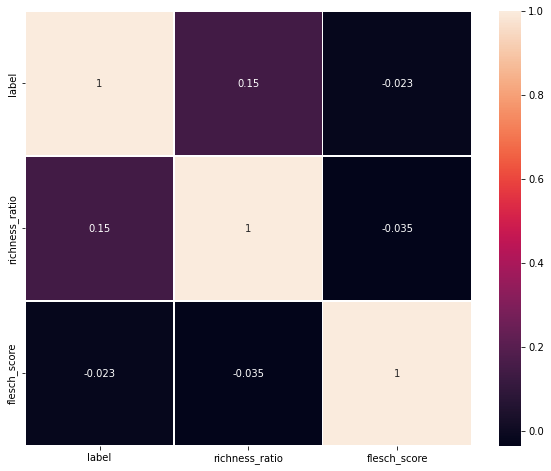

In [38]:
corr_matrix = df.corr()
print(corr_matrix['label'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot = True, linewidths=.5, ax = ax)

### Ploting Histogram

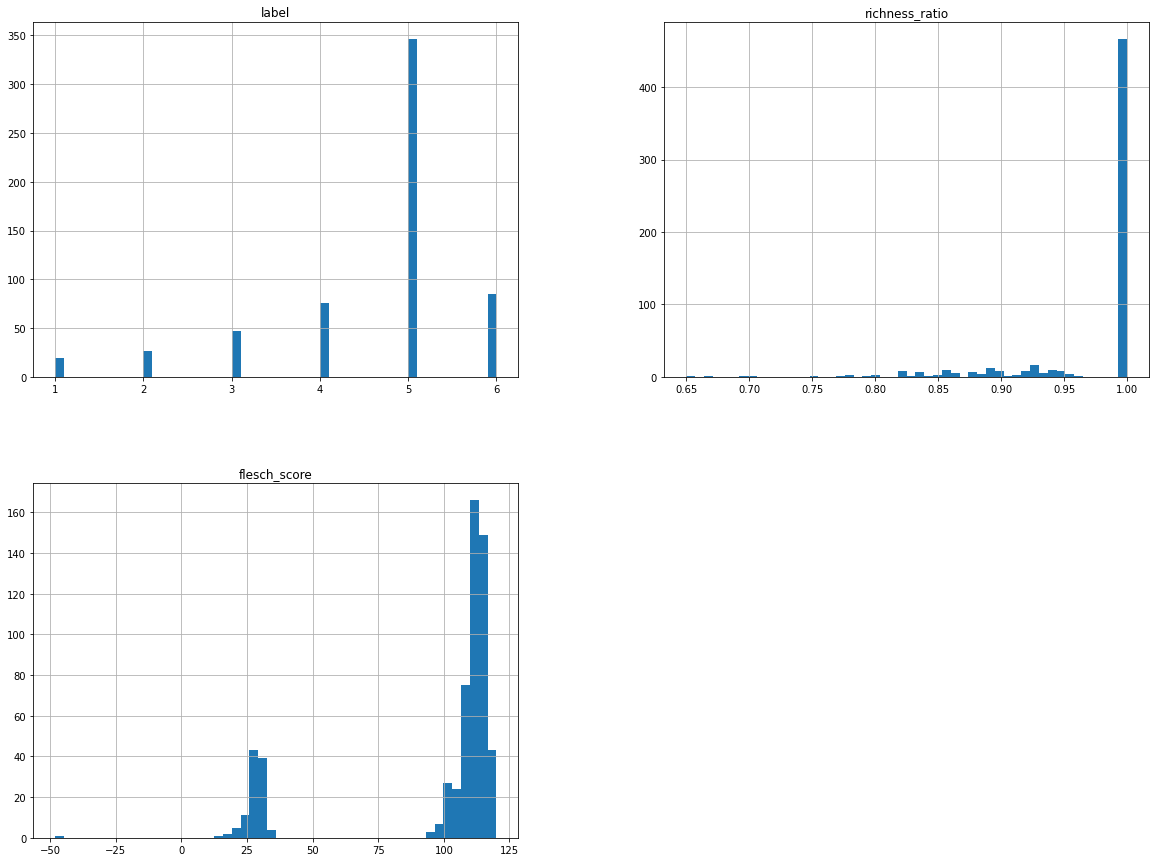

In [39]:
%matplotlib inline

df.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [40]:
print("Skewness: \n",df.skew(),"\n")
print("Kurtosis: \n",df.kurtosis(),"\n")

Skewness: 
 label            -1.422240
richness_ratio   -2.419724
flesch_score     -1.702135
dtype: float64 

Kurtosis: 
 label             1.788556
richness_ratio    6.309193
flesch_score      1.235145
dtype: float64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


### Performing Log transformation as data is skewed

In [41]:
def  plot_feature(plot_1, plot_1_title, plot_2, plot_2_title):
  plt.figure(figsize=(12,10))

  plt.subplot(221)
  g = sns.distplot(plot_1)#df_regression['label']
  g.set_title( plot_1_title + "- Distribution", fontsize=15)
  g.set_xlabel("")
  g.set_ylabel("Frequency", fontsize=12)

  plt.subplot(222)
  g1 = sns.distplot(plot_2) #df_regression['flesch_score']
  g1.set_title(plot_2_title + "- Distribution", fontsize=15)
  g1.set_xlabel("")
  g1.set_ylabel("Frequency", fontsize=12)

In [42]:
df['label'] = np.log1p(df['label'])
df['flesch_score'] = np.log1p(df['flesch_score'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


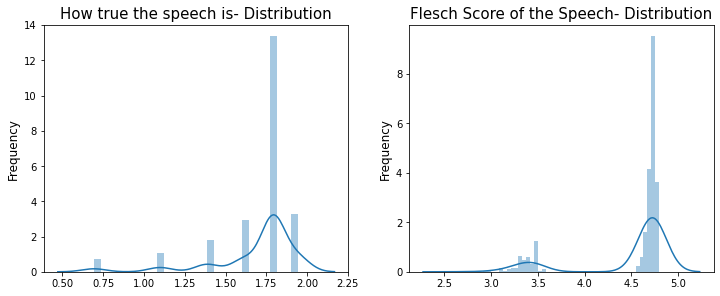

In [43]:
plot_feature(df['label'], "How true the speech is", df['flesch_score'], "Flesch Score of the Speech")

### Split and Train

In [75]:
train_final = train_final[train_final['flesch_score'].notna()]
X = train_final[['richness_ratio', 'flesch_score']].copy()
X.columns

Index(['richness_ratio', 'flesch_score'], dtype='object')

In [76]:
y = train_final['label']

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Correlation between features and target

In [78]:
focus_cols = ['label']
df.corr().filter(focus_cols).drop(focus_cols).style.format('{:.2}')

,label
richness_ratio,0.15
flesch_score,-0.023


## Classification

### Build Classification models

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

#### K nearest neighbors

In [80]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(3) # Define classifier
knn.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Training set performance
knn_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
knn_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
knn_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
knn_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
knn_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
knn_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % knn_train_accuracy)
print('- MCC: %s' % knn_train_mcc)
print('- F1 score: %s' % knn_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % knn_test_accuracy)
print('- MCC: %s' % knn_test_mcc)
print('- F1 score: %s' % knn_test_f1)

Model performance for Training set
- Accuracy: 0.5166666666666667
- MCC: 0.19644329570164876
- F1 score: 0.5041596337458844
----------------------------------
Model performance for Test set
- Accuracy: 0.49166666666666664
- MCC: 0.11540204581100427
- F1 score: 0.4739814814814815


#### Support vector machine (Radial basis function kernel)

In [81]:
from sklearn.svm import SVC

svm_rbf = SVC(gamma=2, C=1)
svm_rbf.fit(X_train, y_train)

# Make predictions
y_train_pred = svm_rbf.predict(X_train)
y_test_pred = svm_rbf.predict(X_test)

# Training set performance
svm_rbf_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
svm_rbf_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
svm_rbf_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
svm_rbf_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
svm_rbf_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
svm_rbf_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % svm_rbf_train_accuracy)
print('- MCC: %s' % svm_rbf_train_mcc)
print('- F1 score: %s' % svm_rbf_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % svm_rbf_test_accuracy)
print('- MCC: %s' % svm_rbf_test_mcc)
print('- F1 score: %s' % svm_rbf_test_f1)

Model performance for Training set
- Accuracy: 0.6
- MCC: 0.20061015215426786
- F1 score: 0.4766182212243856
----------------------------------
Model performance for Test set
- Accuracy: 0.5833333333333334
- MCC: 0.0463647058809434
- F1 score: 0.43209876543209874


#### Decision tree

In [82]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5) # Define classifier
dt.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Training set performance
dt_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
dt_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
dt_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
dt_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
dt_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
dt_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % dt_train_accuracy)
print('- MCC: %s' % dt_train_mcc)
print('- F1 score: %s' % dt_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % dt_test_accuracy)
print('- MCC: %s' % dt_test_mcc)
print('- F1 score: %s' % dt_test_f1)

Model performance for Training set
- Accuracy: 0.6
- MCC: 0.21238940706658974
- F1 score: 0.49567588450400957
----------------------------------
Model performance for Test set
- Accuracy: 0.5166666666666667
- MCC: -0.044829099611870385
- F1 score: 0.40858466390695836


#### Random forest

In [83]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10) # Define classifier
rf.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Training set performance
rf_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
rf_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
rf_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
rf_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
rf_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
rf_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % rf_train_accuracy)
print('- MCC: %s' % rf_train_mcc)
print('- F1 score: %s' % rf_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % rf_test_accuracy)
print('- MCC: %s' % rf_test_mcc)
print('- F1 score: %s' % rf_test_f1)

Model performance for Training set
- Accuracy: 0.6333333333333333
- MCC: 0.31210170771992995
- F1 score: 0.5755942646241693
----------------------------------
Model performance for Test set
- Accuracy: 0.49166666666666664
- MCC: -0.04330956895593777
- F1 score: 0.4064257866889446


#### Neural network

In [84]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1, max_iter=1000)
mlp.fit(X_train, y_train)

# Make predictions
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

# Training set performance
mlp_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
mlp_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
mlp_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
mlp_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
mlp_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
mlp_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % mlp_train_accuracy)
print('- MCC: %s' % mlp_train_mcc)
print('- F1 score: %s' % mlp_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % mlp_test_accuracy)
print('- MCC: %s' % mlp_test_mcc)
print('- F1 score: %s' % mlp_test_f1)

Model performance for Training set
- Accuracy: 0.5770833333333333
- MCC: 0.05865770459461953
- F1 score: 0.4245027431502403
----------------------------------
Model performance for Test set
- Accuracy: 0.5833333333333334
- MCC: 0.0
- F1 score: 0.4298245614035087


## Build Stacked model

In [85]:

# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('knn',knn),
    ('svm_rbf',svm_rbf),
    ('dt',dt),
    ('rf',rf),
    ('mlp',mlp) ]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# Train stacked model
stack_model.fit(X_train, y_train)

# Make predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

# Training set model performance
stack_model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
stack_model_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
stack_model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set model performance
stack_model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
stack_model_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
stack_model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % stack_model_train_accuracy)
print('- MCC: %s' % stack_model_train_mcc)
print('- F1 score: %s' % stack_model_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % stack_model_test_accuracy)
print('- MCC: %s' % stack_model_test_mcc)
print('- F1 score: %s' % stack_model_test_f1)

Model performance for Training set
- Accuracy: 0.5729166666666666
- MCC: -0.02239038651434679
- F1 score: 0.41887417218543044
----------------------------------
Model performance for Test set
- Accuracy: 0.5833333333333334
- MCC: 0.0
- F1 score: 0.4298245614035087


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Classifier Results

In [86]:
acc_train_list = {'knn':knn_train_accuracy,
'svm_rbf': svm_rbf_train_accuracy,
'dt': dt_train_accuracy,
'rf': rf_train_accuracy,
'mlp': mlp_train_accuracy,
'stack': stack_model_train_accuracy}

mcc_train_list = {'knn':knn_train_mcc,
'svm_rbf': svm_rbf_train_mcc,
'dt': dt_train_mcc,
'rf': rf_train_mcc,
'mlp': mlp_train_mcc,
'stack': stack_model_train_mcc}

f1_train_list = {'knn':knn_train_f1,
'svm_rbf': svm_rbf_train_f1,
'dt': dt_train_f1,
'rf': rf_train_f1,
'mlp': mlp_train_f1,
'stack': stack_model_train_f1}

In [87]:
mcc_train_list

{'dt': 0.21238940706658974,
 'knn': 0.19644329570164876,
 'mlp': 0.05865770459461953,
 'rf': 0.31210170771992995,
 'stack': -0.02239038651434679,
 'svm_rbf': 0.20061015215426786}

In [88]:
import pandas as pd

acc_df = pd.DataFrame.from_dict(acc_train_list, orient='index', columns=['Accuracy'])
mcc_df = pd.DataFrame.from_dict(mcc_train_list, orient='index', columns=['MCC'])
f1_df = pd.DataFrame.from_dict(f1_train_list, orient='index', columns=['F1'])
df = pd.concat([acc_df, mcc_df, f1_df], axis=1)
df

,Accuracy,MCC,F1
knn,0.516667,0.196443,0.504160
svm_rbf,0.600000,0.200610,0.476618
dt,0.600000,0.212389,0.495676
rf,0.633333,0.312102,0.575594
mlp,0.577083,0.058658,0.424503
stack,0.572917,-0.022390,0.418874


In [89]:
df.to_csv(file_path_data + '/results.csv')

# Reference

1. https://alternusvera.wordpress.com/
2. https://devopedia.org/text-corpus-for-nlp#summary
3. https://www.corpusdata.org/
4. [Twitter Sentiment Analysis of Trump’s Coronavirus Response](https://medium.com/swlh/coronavirus-python-tutorial-1-520cc960aac1)

1.  https://medium.com/glose-team/how-to-evaluate-text-readability-with-nlp-9c04bd3f46a2
2. https://scholar.smu.edu/cgi/viewcontent.cgi?article=1202&context=datasciencereview
3. https://en.wikipedia.org/wiki/Readability
4. Google Search: nlp reading level detection
5. https://blog.insightdatascience.com/verbiage-using-nlp-to-improve-k-12-content-marketing-8906d2810fda
6. https://www.geeksforgeeks.org/readability-index-pythonnlp/
7. [Scraping Data Off Twitter Using Python | Twitterscraper + NLP + Data Visualization](https://www.youtube.com/watch?v=MpIi4HtCiVk&t=81s)
8. [The Generative Style Transformer](https://medium.com/agara-labs/the-generative-style-transformer-3564bce04d04)
9. [Two minutes NLP — Quick intro to Text Style Transfer](https://medium.com/nlplanet/two-minutes-nlp-quick-intro-to-text-style-transfer-61de9cbd4083)
10. [Reinforcement Learning Based Text Style Transfer without Parallel Training Corpus](https://www.youtube.com/watch?v=r8Cn_0Nb-ng)
11. [Scraping 1000’s of News Articles using 10 simple steps
](https://towardsdatascience.com/scraping-1000s-of-news-articles-using-10-simple-steps-d57636a49755)
12. [Just what is corpus stylistics?](https://www.youtube.com/watch?v=X7vuRzvQ0nQ)
12.[Stylometry Analysis: Text Linguistics Perspective.ipynb](https://gist.github.com/AhmedHani/81bd40ff3ce4d9131f02c89fe099d490)

# Dataset

1. [Trump Twitter Archive](https://www.thetrumparchive.com/)
2. Web Scraping from politifact.com
